------------------------------------------------------------------------------------------------------
Copyright (c) 2019 Rafael Guimaraes

This is part of a doctoral thesis in Economics at UFRGS/Brazil

*Chapter 2 - Mapping GDP with Deep Feedforward Networks*

*Guimaraes, R. & Monteiro, S. & Ziegelmann, F. (2019)*

See full material at https://github.com/rrsguim/PhD_Economics

The code below, under MIT License, is an adaptation of

*Regression: Predict Fuel Efficiency*

Copyright (c) 2017 François Chollet

https://www.tensorflow.org/tutorials/keras/basic_regression

-------------------------------------------------------------------------

# GDPBR19m12

In [1]:
# Use seaborn for pairplot
!pip install seaborn

In [2]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.models import Sequential

print(tf.__version__)

1.13.1


Using TensorFlow backend.


# Get and organize the data

The csv file is available at https://github.com/rrsguim/PhD_Economics

In [3]:
dataset = pd.read_csv("GDP_BR_19_M12_2003_2018.csv", 
                      na_values = "?", comment='\t',
                      sep=";", skipinitialspace=True)
dataset.tail()

,gdp,mining,ind,eletco,eletin,eletot,eletho,constr,retail,export,import,diesel,truckt,jobrtl,jobtrs,jobacc,jobhlt,jobedc,credit
187,0.012619,0.014293,0.017608,0.028783,0.020152,0.031189,0.024050,0.013898,0.040201,0.019618,0.223873,0.038652,0.017667,0.001252,-0.025699,0.002148,0.036612,0.000304,0.129811
188,0.012619,0.001953,-0.025374,-0.012440,0.019115,0.027701,-0.005346,0.010767,0.002240,-0.021922,-0.044192,-0.019842,-0.015464,0.000945,-0.028509,0.003631,0.039868,0.001944,0.089911
189,0.010677,0.038593,0.004246,0.010470,0.009760,0.012151,0.026010,0.045082,0.018529,0.104788,0.098692,0.028672,0.017406,-0.000571,-0.032292,0.004354,0.041813,0.005838,0.145835
190,0.010677,0.030380,-0.016921,0.015508,0.012633,0.025404,0.019608,-0.014835,0.044228,0.189049,0.183863,0.020347,0.006307,-0.002690,-0.034561,0.006633,0.045594,0.013498,0.097504
191,0.010677,0.062878,-0.053713,0.008875,-0.005129,0.038727,0.011350,-0.043553,0.006672,0.107722,-0.039603,0.035291,-0.041713,0.001658,-0.030775,0.009316,0.051366,0.053384,0.077671


# Split in-sample data into train and test

In [0]:
train_dataset = dataset.sample(frac=0.8)#,random_state=0) 
test_dataset = dataset.drop(train_dataset.index)

# Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

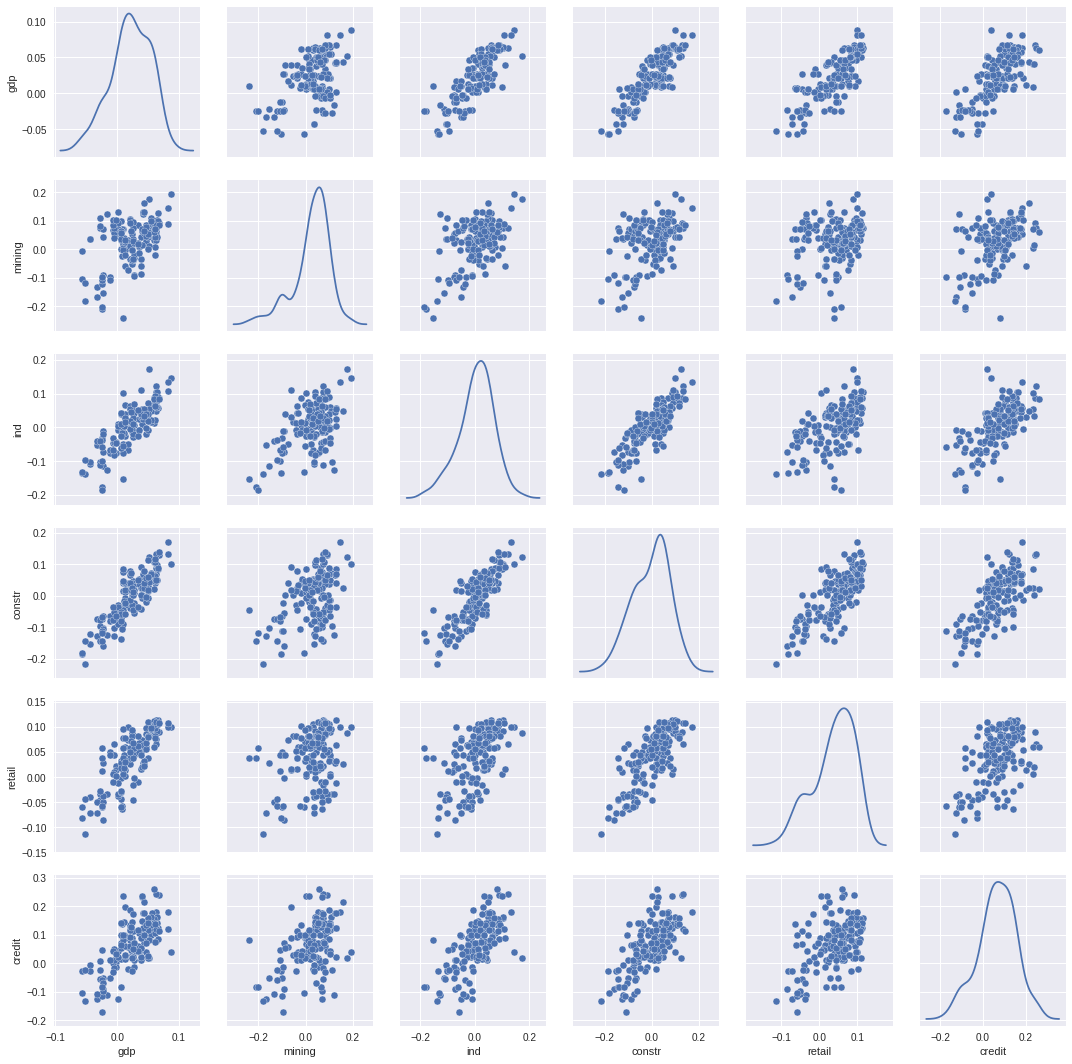

In [5]:
sns.pairplot(train_dataset[["gdp","mining","ind","constr","retail","credit"]], diag_kind="kde")

Also look at the overall statistics:

In [6]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
gdp,154.0,0.022252,0.031490,-0.056797,0.005802,0.024551,0.046838,0.088079
mining,154.0,0.026643,0.077123,-0.240793,-0.001473,0.040839,0.073463,0.193853
ind,154.0,0.005073,0.064750,-0.186126,-0.027871,0.011217,0.046978,0.173444
eletco,154.0,0.040430,0.039938,-0.078082,0.015509,0.044189,0.065655,0.152504
eletin,154.0,0.018437,0.060764,-0.159188,-0.014342,0.013944,0.045967,0.198569
eletot,154.0,0.033172,0.031373,-0.036427,0.009318,0.033956,0.051178,0.127607
eletho,154.0,0.038206,0.035365,-0.058812,0.018502,0.039979,0.057009,0.162016
constr,154.0,-0.002960,0.077045,-0.217244,-0.059785,0.013316,0.049311,0.171312
retail,154.0,0.038128,0.052469,-0.112287,0.010271,0.048931,0.081107,0.113713
export,154.0,0.041607,0.108511,-0.297267,-0.012436,0.044195,0.102439,0.353409


# Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

It is important to note that the split process nullifies the time dependent characteristic of the series. Due to our cross-sectional approach, this is acceptable and even desirable. 

In [0]:
train_labels = train_dataset.pop('gdp')
test_labels = test_dataset.pop('gdp')

# Build and inspect the model

Let's build our model. Here, we'll use a Sequential model with four densely connected hidden layers, and an output layer that returns a single, continuous value. 


In [8]:
def build_model():
    model = Sequential([
        keras.layers.Dense(150, kernel_regularizer=keras.regularizers.l1(0.001), 
                           activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), 
                           activation=tf.nn.relu),
        keras.layers.Dense(50, kernel_regularizer=keras.regularizers.l1(0.001), 
                           activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.train.ProximalAdagradOptimizer(0.001)
    
    model.compile(loss='mse', 
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               2850      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 23,051
Trainable params: 23,051
Non-trainable params: 0
_________________________________________________________________


# Train the model

Train the model for 2500 epochs, and record the training and validation accuracy in the history object.

In [9]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2500

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

Now we take a batch of 5 examples from the training data and call model.predict on it to see if the results are as expected in terms of shape and type.

In [10]:
example_batch = train_dataset[:5]
example_result = model.predict(example_batch).flatten()
example_result

array([0.05475621, 0.02169445, 0.04249375, 0.01182822, 0.04325828],
      dtype=float32)

Visualize the model's training progress using the stats stored in the history object.

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
2495,1.284853,0.010552,0.000174,1.284766,0.011766,0.000230,2495
2496,1.284628,0.010553,0.000174,1.284541,0.011766,0.000230,2496
2497,1.284403,0.010553,0.000174,1.284317,0.011767,0.000231,2497
2498,1.284179,0.010555,0.000174,1.284092,0.011767,0.000230,2498
2499,1.283954,0.010554,0.000174,1.283867,0.011767,0.000231,2499


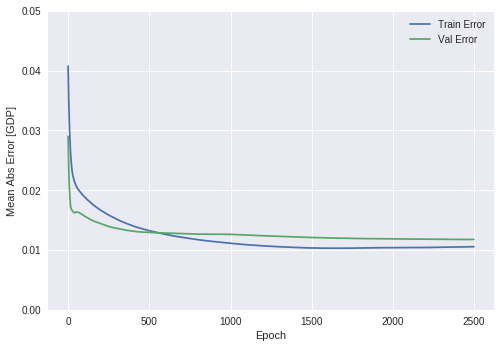

In [12]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [GDP]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.05])
  plt.legend()

  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [13]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set MAE: {:5.4f} GDP".format(mae))

Testing set MAE: 0.0140 GDP


# Making prediction

Predict GDP values using data in the testing set:

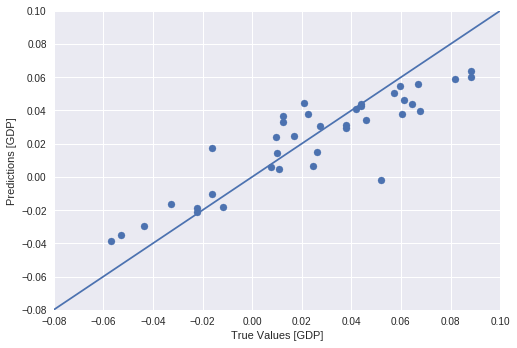

In [14]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [GDP]')
plt.ylabel('Predictions [GDP]')
plt.xlim([-0.08,0.1])
plt.ylim([-0.08,0.1])
_ = plt.plot([-1, 1], [-1, 1])

Let's take a look at the error distribution.

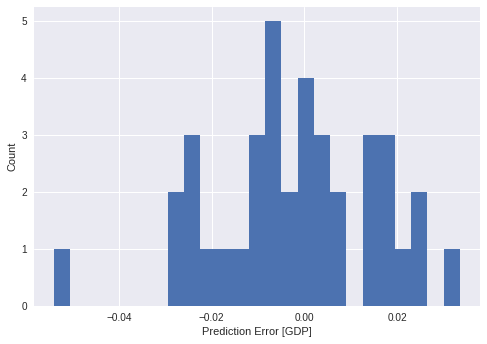

In [15]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [GDP]")
_ = plt.ylabel("Count")

Finally, we visually inspect and export to a csv file the observed and the reconstructed GDP for all period, including out-of-sample.

In [0]:
dataset_copy = dataset
y = dataset_copy.pop('gdp')
x = dataset_copy

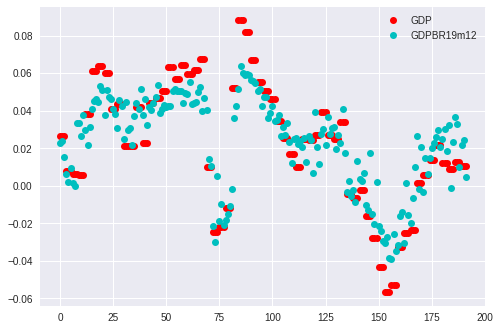

In [17]:
GDPBR19m12 = model.predict(x).flatten()
time_axis = range(0,y.shape[0]) 
plt.plot(time_axis, y.T, 'ro', label='GDP') #target
plt.plot(time_axis, GDPBR19m12.T, 'co', label='GDPBR19m12') #model
plt.legend()
plt.show()

In [0]:
#export output to csv file
import datetime
now = datetime.datetime.now().strftime("%Y%m%d_%Hh%M")
a = np.asarray(GDPBR19m12)
np.savetxt("GDPBR19m12_"+now+".csv", a, delimiter=",")